Here I am using the "California Housing Prices"  [link of dataset](https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv). It is a regression dataset suitable for testing Gradient Boosting. This dataset is also available on Kaggle.

## Download and Preparing the Dataset


In [ ]:
import pandas as pd

# Load the dataset
url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"
data = pd.read_csv(url)

# Display the first few rows
print(data.head())


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


## Data Preprocessing

We’ll preprocess the data to make it ready for training. Steps include:

- Handling missing values.
- Encoding categorical variables.
- Splitting the dataset into training and testing sets.
- Standardizing the features.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Fill missing values
data['total_bedrooms'] = data['total_bedrooms'].fillna(data['total_bedrooms'].median())

# One-hot encoding for categorical variable
data = pd.get_dummies(data, columns=['ocean_proximity'], drop_first=True)

# Features and target
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Step 4: Implementing Gradient Boosting from Scratch

Gradient Boosting combines weak learners iteratively to minimize a loss function. Here’s the plan:

Initialize the predictions with a baseline (e.g., mean of target values).

Iteratively add weak learners:

Compute pseudo-residuals (negative gradient of loss).

Fit a weak learner (e.g., small decision tree) to residuals.
Update predictions using the weak learner.

## Initialize Predictions

The first step in Gradient Boosting is to initialize predictions with a constant value (usually the mean of the target for regression).

In [ ]:
import numpy as np

# Initialize predictions with the mean of the target
y_train_mean = np.mean(y_train)
pred_train = np.full_like(y_train, y_train_mean, dtype=np.float64)
pred_test = np.full_like(y_test, y_train_mean, dtype=np.float64)

print(f"Initial train predictions: {pred_train[:5]}")
print(f"Initial test predictions: {pred_test[:5]}")


Initial train predictions: [207194.69373789 207194.69373789 207194.69373789 207194.69373789
 207194.69373789]
Initial test predictions: [207194.69373789 207194.69373789 207194.69373789 207194.69373789
 207194.69373789]


## Define a Weak Learner

We will use a simple decision tree regressor as the weak learner. A tree with limited depth works well in Gradient Boosting.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Weak learner parameters
tree_params = {"max_depth": 3, "random_state": 42}

# Example of fitting a single weak learner
tree = DecisionTreeRegressor(**tree_params)
residuals = y_train - pred_train
tree.fit(X_train, residuals)

# Predict residuals for training and testing
train_leaf_preds = tree.predict(X_train)
test_leaf_preds = tree.predict(X_test)

print(f"Train leaf predictions: {train_leaf_preds[:5]}")
print(f"Test leaf predictions: {test_leaf_preds[:5]}")


Train leaf predictions: [ 29471.81326316  29471.81326316  29471.81326316 -36283.2536713
 -66254.27084988]
Test leaf predictions: [-116040.80771397 -116040.80771397   29471.81326316  104573.01199524
   29471.81326316]


## Update Predictions

Gradient Boosting updates predictions iteratively. We’ll use a learning rate (
𝜂
η) to scale updates.

In [ ]:
# Learning rate
learning_rate = 0.1

# Update predictions
pred_train += learning_rate * train_leaf_preds
pred_test += learning_rate * test_leaf_preds

print(f"Updated train predictions: {pred_train[:5]}")
print(f"Updated test predictions: {pred_test[:5]}")


Updated train predictions: [210141.8750642  210141.8750642  210141.8750642  203566.36837076
 200569.2666529 ]
Updated test predictions: [195590.61296649 195590.61296649 210141.8750642  217651.99493741
 210141.8750642 ]


## Iterate to Build the Model

Now, we’ll implement the full Gradient Boosting algorithm by iterating over a number of boosting rounds (estimators).

In [ ]:
# Number of boosting rounds
n_estimators = 100
trees = []

# Gradient Boosting iterations
for i in range(n_estimators):
    # Compute residuals
    residuals = y_train - pred_train

    # Fit weak learner to residuals
    tree = DecisionTreeRegressor(**tree_params)
    tree.fit(X_train, residuals)

    # Store the trained tree
    trees.append(tree)

    # Predict residuals and update predictions
    train_leaf_preds = tree.predict(X_train)
    test_leaf_preds = tree.predict(X_test)

    pred_train += learning_rate * train_leaf_preds
    pred_test += learning_rate * test_leaf_preds

    # Log the progress every 10 steps
    if (i + 1) % 10 == 0:
        train_loss = np.mean((y_train - pred_train) ** 2)
        test_loss = np.mean((y_test - pred_test) ** 2)
        print(f"Iteration {i+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")


Iteration 10: Train Loss = 6034818586.7547, Test Loss = 6135071725.8050
Iteration 20: Train Loss = 4848958149.3479, Test Loss = 5058034026.5379
Iteration 30: Train Loss = 4235810507.1214, Test Loss = 4448921329.3216
Iteration 40: Train Loss = 3859912965.1434, Test Loss = 4103170265.2668
Iteration 50: Train Loss = 3536395252.2230, Test Loss = 3796332851.5490
Iteration 60: Train Loss = 3334017419.0099, Test Loss = 3603816003.0913
Iteration 70: Train Loss = 3147370863.9091, Test Loss = 3430934636.8676
Iteration 80: Train Loss = 3031836491.7549, Test Loss = 3332762881.3748
Iteration 90: Train Loss = 2878091716.1863, Test Loss = 3190840056.0138
Iteration 100: Train Loss = 2791507476.8991, Test Loss = 3121099344.8783


## Evaluate the Model

After training, we’ll compute metrics like Mean Squared Error (MSE) or R² score.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Final evaluation
mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(f"Train MSE: {mse_train:.4f}, Test MSE: {mse_test:.4f}")
print(f"Train R²: {r2_train:.4f}, Test R²: {r2_test:.4f}")


Train MSE: 2791507476.8991, Test MSE: 3121099344.8783
Train R²: 0.7912, Test R²: 0.7618


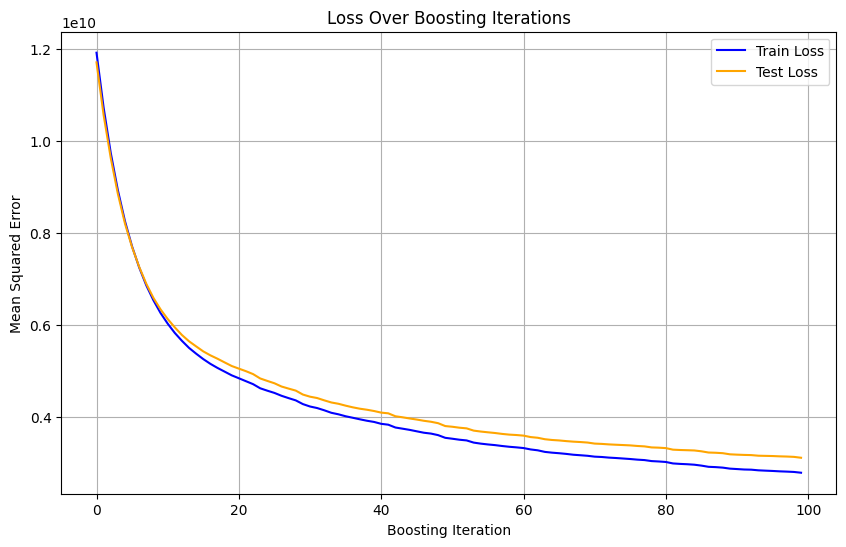

In [ ]:
import matplotlib.pyplot as plt

# Track losses during training
train_losses = []
test_losses = []

# Re-run the boosting iterations to collect loss data
pred_train = np.full_like(y_train, y_train_mean, dtype=np.float64)
pred_test = np.full_like(y_test, y_train_mean, dtype=np.float64)

for i in range(n_estimators):
    residuals = y_train - pred_train
    tree = DecisionTreeRegressor(**tree_params)
    tree.fit(X_train, residuals)

    train_leaf_preds = tree.predict(X_train)
    test_leaf_preds = tree.predict(X_test)

    pred_train += learning_rate * train_leaf_preds
    pred_test += learning_rate * test_leaf_preds

    train_losses.append(mean_squared_error(y_train, pred_train))
    test_losses.append(mean_squared_error(y_test, pred_test))

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(n_estimators), train_losses, label="Train Loss", color="blue")
plt.plot(range(n_estimators), test_losses, label="Test Loss", color="orange")
plt.xlabel("Boosting Iteration")
plt.ylabel("Mean Squared Error")
plt.title("Loss Over Boosting Iterations")
plt.legend()
plt.grid(True)
plt.show()
